In [14]:
import pandas as pd
import numpy as np
import os, sys

In [15]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
from torch.utils.data.dataset import random_split

In [17]:
from time import sleep

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [19]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
def to_onehot(labels, n_categories, dtype=torch.float32):
    batch_size = len(labels)
    one_hot_labels = torch.zeros(size=(batch_size, n_categories), dtype=dtype)
    for i, label in enumerate(labels):
        # Subtract 1 from each LongTensor because your
        # indexing starts at 1 and tensor indexing starts at 0
        label = torch.LongTensor(label)
        one_hot_labels[i] = one_hot_labels[i].scatter_(dim=0, index=label, value=1.)
    return one_hot_labels

In [21]:
DATA_FOLDER = '../data'
FILE = 'train.csv'
DATA_PATH = '../data/ml-latest-small'

In [22]:
links_df = pd.read_csv(os.path.join(DATA_PATH, 'links.csv'))

In [23]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv')).query("rating >= 4").drop(columns=['rating', 'timestamp'])

In [24]:
contentMovie_df = pd.read_csv(os.path.join(DATA_FOLDER, FILE))

In [25]:
from gensim.models import Word2Vec
import torch.nn.functional as F
import spacy
nlp = spacy.load("en_core_web_sm")
spacy_sw = spacy.lang.en.stop_words.STOP_WORDS

def fct(doc):
    return ' '.join([w.lemma_ for w in doc 
            if w.lemma_ not in spacy_sw and 
            not w.is_punct and 
            w.tag_ != 'VBN'
           ])


def create_weight(text):
    desc = list(text)
    desc = [d 
            if type(d) is not np.float 
            else 'Nothing' 
            for d in desc]
    docs = nlp.pipe(desc)
    split_d = [fct(doc).split() for doc in docs]
    model_emb_w = Word2Vec(split_d, min_count=10, size=64)
    weights = torch.FloatTensor(model_emb_w.wv.vectors)
    weights = torch.cat((weights, weights.mean(0, keepdim=True)), dim=0)
    return weights, model_emb_w, split_d

In [26]:
text_df = contentMovie_df.iloc[:,:2]

In [27]:
id_desc = set(text_df.movieId)

In [28]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv')).query("rating >= 3 and movieId in @id_desc").drop(columns=['rating', 'timestamp'])

In [29]:
img2id = {links_df.imdbId[i]: links_df.movieId[i] for i in range(len(links_df))}

In [30]:
id_img = [img2id[i] for i in list_img]

NameError: name 'list_img' is not defined

In [130]:
m_id = set((ratings_df.movieId.value_counts()[ratings_df.movieId.value_counts() > 5]).index)
u_id = set((ratings_df.userId.value_counts()[ratings_df.userId.value_counts() > 5]).index)
ratings_df.query("movieId in @m_id & userId in @u_id", inplace=True)
ratings_df.query('movieId in @id_img', inplace=True)

In [120]:
id2id = {e: i for i, e in enumerate(text_df.movieId.unique())}
ratings_df['movieId'] = ratings_df.movieId.map(id2id)

In [71]:
weights, model, split_d = create_weight(text_df.description)

In [72]:
vocab = list(model.wv.vocab)

In [73]:
word2id = [torch.LongTensor([vocab.index(w) for w in s if w in vocab]) for s in split_d]
# the final term is for padding
pad_int = len(vocab)

In [133]:
len([i for i in id_img if i not in set(ratings_df.movieId.unique())])

333

In [51]:
def Neg_Sample(x):
    line = (1  - x).nonzero()
    line = line[torch.multinomial(torch.ones(line.size(0)), 10, True)].t()
    return line

In [87]:
class RecoDataset(Dataset):
    def __init__(self, data, itemId, userId, word2id):
        
        self.itemId, self.userId = torch.LongTensor(data[itemId]), torch.LongTensor(data[userId])
        self.n_user, self.n_item = len(self.userId.unique()), len(self.itemId.unique())
        self.n = len(self.itemId)
        list_item = data.groupby(userId).agg(list)[itemId]
        ohe = to_onehot([list_item[u.item()] for u in self.userId], self.itemId.max() + 1, dtype=torch.float32)
        self.neg_samp = torch.cat([self.Neg_Sample(ohe[i]) for i in range(self.n)])
        
        desc_id = torch.nn.utils.rnn.pad_sequence(word2id, padding_value=pad_int, batch_first=True)
        self.movie_description = desc_id[self.itemId]
        
    def Neg_Sample(self, x):
        line = (1  - x).nonzero()
        line = line[torch.multinomial(torch.ones(line.size(0)), 3, True)].t()
        return line

    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return (self.itemId[idx], self.userId[idx], self.movie_description[idx], self.neg_samp[idx])

In [88]:
split= 0.8

In [89]:
dataset = RecoDataset(ratings_df, 'movieId', 'userId', word2id)
lengths = [int(dataset.__len__() * split), int(dataset.__len__() * (1-split)) + 1]
lengths = lengths if sum(lengths) == dataset.__len__() else [lengths[0], lengths[1] - 1]
train_data, test_data = random_split(dataset, lengths)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

RuntimeError: invalid argument 1: tensor must have one dimension at c:\a\w\1\s\tmp_conda_3.7_070403\conda\conda-bld\pytorch-cpu_1550387224787\work\aten\src\th\generic/THTensorEvenMoreMath.cpp:590

In [179]:
class RecoWithText(nn.Module):
    
    def __init__(self, nItem, nUser, dim):
        super(RecoWithText, self).__init__()

        ## GMF
        self.embedding_user_gmf = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=dim)
        self.embedding_item_gmf = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=dim)      
        ## MLP
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=dim)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=dim)
        self.nnItem = nn.Sequential(
            nn.Linear(dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnUser = nn.Sequential(
            nn.Linear(dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnFusion = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, dim),
        )
        # total
        self.affine_output = nn.Linear(in_features=dim+dim+dim, out_features=1) #out_features=nItem)
        
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.fc1 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, dim)
        )
        
        self.logistic = nn.Sigmoid()  
        
    def forward(self, item, user, d):
        # GMF
        user_embedding_gmf = self.embedding_user_gmf(user)
        item_embedding_gmf = self.embedding_item_gmf(item)        
        x_gmf = torch.mul(user_embedding_gmf, item_embedding_gmf)
        # MLP
        user_embedding_mlp = self.embedding_user_mlp(user)
        item_embedding_mlp = self.embedding_item_mlp(item)
        x1 = self.nnItem(item_embedding_mlp)
        x2 = self.nnUser(user_embedding_mlp)
        x_mlp = torch.cat((x1, x2), dim=1)
        x_mlp = self.nnFusion(x_mlp)     
        # text layer
        d = self.embedding(d)
        d = d.mean(dim=1)
        d = self.fc1(d)
        # concat the two models
        vector = torch.cat((x_mlp, x_gmf, d), dim=1)   
        x = self.affine_output(vector)
        
        # x = self.logistic(logits)   
        return x

In [168]:
class RecoWithoutText(nn.Module):
    
    def __init__(self, nItem, nUser, dim):
        super(RecoWithoutText, self).__init__()

        ## GMF
        self.embedding_user_gmf = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=dim)
        self.embedding_item_gmf = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=dim)      
        ## MLP
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=dim)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=dim)
        self.nnItem = nn.Sequential(
            nn.Linear(dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnUser = nn.Sequential(
            nn.Linear(dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnFinal = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, dim),
        )
        # total
        self.affine_output = nn.Linear(in_features=dim+dim, out_features=1)
        self.logistic = nn.Sigmoid()  
        
    def forward(self, item, user):
        # GMF
        user_embedding_gmf = self.embedding_user_gmf(user)
        item_embedding_gmf = self.embedding_item_gmf(item)        
        x_gmf = torch.mul(user_embedding_gmf, item_embedding_gmf)
        # MLP
        user_embedding_mlp = self.embedding_user_mlp(user)
        item_embedding_mlp = self.embedding_item_mlp(item)
        x1 = self.nnItem(item_embedding_mlp)
        x2 = self.nnUser(user_embedding_mlp)
        x_mlp = torch.cat((x1, x2), dim=1)
        x_mlp = self.nnFinal(x_mlp)
        # concat the two models
        vector = torch.cat((x_mlp, x_gmf), dim=1)
        x = self.affine_output(vector)

        return x

In [180]:
R = RecoWithText(ratings_df.movieId.max()+1, ratings_df.userId.max()+1, 32)

In [169]:
R = RecoWithoutText(ratings_df.movieId.max()+1, ratings_df.userId.max()+1, 32)

In [181]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adadelta(R.parameters())

In [182]:
all_losses = []
batches = 0

In [183]:
start = time.time()

for epoch in range(15):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        items, users, d, neg_samp = data
        
        batch_size = items.size(0)

        pos_target = torch.ones(batch_size, 1)
        neg_target = torch.zeros(batch_size, 1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_pos = R(items, users, d)
        loss_neg = torch.tensor([0.])
        for i_neg in neg_samp.t():
            outputs_neg = R(i_neg, users, d)
            loss_neg += criterion(outputs_neg, neg_target)
            
        loss = (criterion(outputs_pos, pos_target) + loss_neg / 3)/2
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 500 == 0:
            print('%s, %d %d %.4f' % (timeSince(start), epoch, batches, loss))
        all_losses.append(loss.item())
        batches += 1

print('Finished Training')

0m 0s, 0 0 0.6848
0m 3s, 1 383 0.4524
0m 7s, 2 766 0.4092
0m 12s, 3 1149 0.4299
0m 16s, 4 1532 0.3732
0m 20s, 5 1915 0.3318
0m 24s, 6 2298 0.3942
0m 28s, 7 2681 0.3348
0m 32s, 8 3064 0.3860
0m 36s, 9 3447 0.3901
0m 41s, 10 3830 0.3301
0m 45s, 11 4213 0.3243
0m 49s, 12 4596 0.3960
0m 53s, 13 4979 0.3514
0m 58s, 14 5362 0.3497
Finished Training


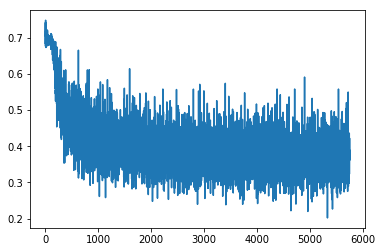

In [184]:
plt.figure()
plt.plot(all_losses)

## Evaluation

In [185]:
correct = 0
correct_neg = 0
correct_pos = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        items, users, d, neg_samp = data
        batch_size = items.size(0)
        pos_target = torch.ones(batch_size, 1)
        neg_target = torch.zeros(batch_size, 1)
        outputs_pos = R(items, users, d)
        loss_neg = torch.tensor([0])
        for i_neg in neg_samp.t():
            outputs_neg = R(i_neg, users, d)
            loss_neg += criterion(outputs_neg, neg_target)
            
        total += pos_target.size(0)
        correct_pos += criterion(outputs_pos, pos_target).item()
        correct_neg += (loss_neg / 3).item()

In [186]:
(correct_pos + correct_neg) / total

0.011447028790440612

In [187]:
correct_pos / total

0.011447028790440612

In [190]:
args = (test_data.dataset.itemId,
test_data.dataset.userId,
test_data.dataset.movie_description)
n = test_data.dataset.n

In [191]:
sum((nn.Sigmoid()(R(*args))).round()).item() / n

0.894166067812112

### En cours (image part)

In [31]:
import sys
from PIL import Image
from io import BytesIO

In [32]:
sys.path.append('../script')

In [33]:
from img2vec import Img2Vec

In [34]:
resnet50 = Img2Vec()

In [35]:
PATH = '../data/traindata/image'

In [37]:
l_file = os.listdir(PATH)

In [38]:
list_img = [int(i.replace('.jpeg', '')) for i in l_file]

In [39]:
f = l_file[0]
def give_vect(f):
    img = Image.open(os.path.join(PATH, f))
    vec = resnet50.get_vec(img, tensor=True)
    return vec

In [40]:
matrix_img = torch.cat([give_vect(i) for i in l_file])

In [41]:
matrix_img = matrix_img.view(741, 2048)

In [42]:
class RecoImageTextDataset(Dataset):
    def __init__(self, data, itemId, userId, word2id):
        
        self.itemId, self.userId = torch.LongTensor(data[itemId]), torch.LongTensor(data[userId])
        self.n_user, self.n_item = len(self.userId.unique()), len(self.itemId.unique())
        self.n = len(self.itemId)
        list_item = data.groupby(userId).agg(list)[itemId]
        print(list_item)
        ohe = to_onehot([list_item[u.item()] for u in self.userId], self.itemId.max() + 1, dtype=torch.float32)
        self.neg_samp = torch.cat([self.Neg_Sample(ohe[i]) for i in range(self.n)])
        
        desc_id = torch.nn.utils.rnn.pad_sequence(word2id, padding_value=pad_int, batch_first=True)
        self.movie_description = desc_id[self.itemId]
        
    def Neg_Sample(self, x):
        line = (1  - x).nonzero()
        line = line[torch.multinomial(torch.ones(line.size(0)), 3, True)].t()
        return line

    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return (self.itemId[idx], self.userId[idx], self.movie_description[idx], self.image, self.neg_samp[idx])

In [43]:
split= 0.8

In [44]:
dataset = RecoImageTextDataset(ratings_df, 'movieId', 'userId', word2id)
lengths = [int(dataset.__len__() * split), int(dataset.__len__() * (1-split)) + 1]
lengths = lengths if sum(lengths) == dataset.__len__() else [lengths[0], lengths[1] - 1]
train_data, test_data = random_split(dataset, lengths)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

NameError: name 'word2id' is not defined

In [53]:
desc_id = torch.nn.utils.rnn.pad_sequence(word2id, padding_value=pad_int, batch_first=True)